#1. Setup and Installation

In [17]:
# # Install required packages
# !pip install torch transformers peft accelerate bitsandbytes -q
# !pip install tqdm psutil trl -q
# !pip install -U sympy           # or  !pip install -U sympy  in a notebook

# # Create directories
# !mkdir -p rlvr_adapter
# !mkdir -p offload_folder

#2. Imports and Logging Setup


In [18]:
import os
import torch
import numpy as np
import gc
from datetime import datetime
from accelerate import Accelerator
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    get_scheduler
)
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
import logging
import psutil
import matplotlib.pyplot as plt
from google.colab import auth
import warnings
# Import datasets library for GSM8K
from datasets import load_dataset

# Add this to your imports section
import re
import json
warnings.filterwarnings('ignore')

# Configure basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Memory efficiency configurations
torch.backends.cuda.matmul.allow_tf32 = True  # Better performance with reduced precision
torch.backends.cudnn.allow_tf32 = True

# Check for available GPU
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU available: True
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB


#3. Configuration and Paths

In [19]:
# Helper function for securely setting HF token
from getpass import getpass
import os
from google.colab import userdata


# Set Hugging Face token (enter when prompted)
def setup_hf_token():
    if userdata.get("HF_TOKEN") is None:
        token = getpass("Enter your Hugging Face token: ")
        os.environ["HF_TOKEN"] = token
    return os.environ["HF_TOKEN"]

# Call the function
AUTH_TOKEN = userdata.get("HF_WRITE_TOKEN")

# Set up paths and configuration
BASE_MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"  # Base model name

# Paths - adjusted for Colab
ADAPTER_PATH = "rlvr_adapter"
OFFLOAD_FOLDER = "offload_folder"

# RLVR Hyperparameters - adjusted for faster training in Colab
LEARNING_RATE = 1e-5
VALUE_MARGIN = 0.1  # Replacing CLIP_EPSILON - this is the margin for the value constraint
KL_PENALTY = 0.1
VALUE_COEF = 0.5  # Can remain the same
ENTROPY_COEF = 0.01  # Can remain the same
NUM_EPOCHS = 2  # Keeping reduced value for Colab
BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 4  # Keeping reduced value for Colab
MAX_SEQ_LENGTH = 256  # Keeping reduced value for Colab
MAX_GRAD_NORM = 1.0  # Can remain the same
GAMMA = 0.99  # Discount factor can remain the same
GAE_LAMBDA = 0.95  # GAE lambda can remain the same
DELTA = 0.2  # tolerance for the trust region

# LoRA Configuration - optimized for Colab
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "v_proj",
        "o_proj",
    ],
)

#4. Utility Functions


In [20]:
def log_memory_usage(stage=""):
    """Log current memory usage for debugging."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**2
        reserved = torch.cuda.memory_reserved() / 1024**2
        logger.info(f"{stage} - GPU Memory: {allocated:.2f}MB allocated, {reserved:.2f}MB reserved")

        # Plot memory usage
        plt.figure(figsize=(10, 2))
        plt.bar(['Allocated', 'Reserved'], [allocated, reserved])
        plt.ylabel('Memory (MB)')
        plt.title(f'GPU Memory Usage - {stage}')
        plt.show()

    process = psutil.Process()
    ram = process.memory_info().rss / 1024**2
    logger.info(f"{stage} - RAM Usage: {ram:.2f}MB")

def format_math_prompt(question):
    """Format a math question with proper instructions for GSM8K."""
    # Instructions for how to structure the answer
    instructions = """You are a math problem solver. Please solve problems step by step, following these rules:
    1) Start with noting all facts from the problem.
    2) Perform inner calculations inside double angle brackets, like <<calculation=result>>.
    3) Write the final answer in a new line with a #### prefix."""

    # Format according to Llama 3.1 chat template
    prompt = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{instructions}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\n{question}<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>\n"
    return prompt

#5. Model Loading


In [21]:
def load_model():
    # Load tokenizer as before
    tokenizer = AutoTokenizer.from_pretrained(
        BASE_MODEL_NAME,
        token=AUTH_TOKEN
    )

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Modified quantization config - remove CPU offloading
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
        # Removed: llm_int8_enable_fp32_cpu_offload=True
    )

    # Load policy model without device_map
    policy_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config,
        token=AUTH_TOKEN,
        torch_dtype=torch.float16
    )

    # Continue with adapter preparation as before
    policy_model = prepare_model_for_kbit_training(policy_model)
    policy_model = get_peft_model(policy_model, lora_config)

    # Similar changes for reference_model
    reference_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config,
        token=AUTH_TOKEN,
        torch_dtype=torch.float16
    )

    # Continue with value head creation as before
    # ...

    log_memory_usage("After reference model")

    # Freeze reference model
    for param in reference_model.parameters():
        param.requires_grad = False

    # Create value head on top of policy model
    value_head = torch.nn.Linear(
        policy_model.config.hidden_size,
        1
    ).to(policy_model.device)

    # Memory optimization: Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    return policy_model, reference_model, value_head, tokenizer

# Section 6: Dataset Loading and Preparation


In [22]:
from datasets import load_dataset
import re
import json
import time
import torch.nn.functional as F
from torch.optim import AdamW

def load_gsm8k_dataset():
    """Load and prepare the GSM8K dataset for training."""
    logger.info("Loading GSM8K dataset...")
    ds = load_dataset("openai/gsm8k", "main")

    # Extract training and test sets
    train_ds = ds["train"].select(range(800))
    test_ds = ds["test"].select(range(200))

    logger.info(f"Dataset loaded: {len(train_ds)} training examples, {len(test_ds)} test examples")
    return train_ds, test_ds

def format_instructions():
    """Generate the instruction for how to structure math responses."""
    instructions = """
    Please solve this math problem step by step, following these rules:
    1) Start by noting all the facts from the problem.
    2) Show your work by performing inner calculations inside double angle brackets, like <<calculation=result>>.
    3) You MUST write the final answer on a new line with a #### prefix.
    Note - each answer must be of length <= 400.
    """
    return instructions

def format_math_prompt(question):
    """Format a math question with proper instructions."""
    instructions = format_instructions()
    # Format according to Llama 3.1 chat template
    prompt = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n{instructions}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\n{question}<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>\n"
    return prompt

def extract_answer(response):
    """Extract the final answer (number after ####) from a model response."""
    # Look for the final answer format: #### number
    answer_match = re.findall(r'-?\d+\.?\d*', response)
    if answer_match:
        try:
            # Extract and convert to number
            return float(answer_match[-1])
        except ValueError:
            return None
    return None

def verify_answer(generated_answer, reference_answer):
    """Compare the generated answer with the reference answer from the dataset."""
    # Extract the reference answer (usually at the end of the reference string)
    ref_match = re.findall(r'(?<=#### )-?\d+\.?\d*', reference_answer)
    # for ref answer we should use #### d+ regex, as it is always structured like this

    if ref_match and generated_answer is not None:
        try:
            reference_value = float(float(ref_match[-1]))
            # Check if the answers match (allowing for small floating point differences)
            return abs(generated_answer - reference_value) < 1e-6
        except ValueError:
            return False

    return False

# Section 7: RLVR Training Components


In [23]:
def prepare_model_inputs(tokenizer, questions, device, max_length=MAX_SEQ_LENGTH):
    """Tokenize questions and prepare inputs for the model."""
    prompts = [format_math_prompt(q) for q in questions]
    inputs = tokenizer(prompts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    return {k: v.to(device) for k, v in inputs.items()}

def generate_responses(model, tokenizer, inputs, max_new_tokens=1000):
    """Generate responses from the model for given inputs."""
    # Set the pad token ID to avoid generation warnings
    generation_config = {
        "do_sample": True,
        "temperature": 0.7,
        "max_new_tokens": max_new_tokens,
        "pad_token_id": tokenizer.pad_token_id,
    }

    # Generate responses
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            **generation_config
        )

    # Extract only the newly generated tokens for each sample (excluding input prompt)
    generated_texts = []
    for i, output in enumerate(outputs):
        input_length = inputs["input_ids"][i].size(0)
        generated_tokens = output[input_length:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        generated_texts.append(generated_text)

    return generated_texts

def calculate_rewards(generated_responses, reference_answers):
    """Calculate rewards based on answer correctness."""
    rewards = []

    for gen_resp, ref_ans in zip(generated_responses, reference_answers):
        gen_answer = extract_answer(gen_resp)
        is_correct = verify_answer(gen_answer, ref_ans)

        # Binary reward: 1.0 for correct, 0.0 for incorrect
        reward = 1.0 if is_correct else 0.0
        rewards.append(reward)

    return torch.tensor(rewards, dtype=torch.float32)

def calculate_values(policy_model, value_head, inputs):
    """Calculate values using the value head on top of the policy model."""
    with torch.no_grad():
        # Get hidden states from the model's last layer
        outputs = policy_model(**inputs, output_hidden_states=True)
        # Use the last hidden state of the last token for each sequence
        last_hidden_states = outputs.hidden_states[-1][:, -1, :]
        # Get value estimates
        values = value_head(last_hidden_states).squeeze(-1)

    return values

def compute_rlvr_loss(policy_model, reference_model, value_head, tokenizer,
                     inputs, rewards, kl_penalty=KL_PENALTY, value_margin=VALUE_MARGIN):
    """
    Compute the RLVR loss combining:
    1. A policy loss based on value-guided updates
    2. A value loss that trains the value function
    3. A KL penalty to keep close to the reference model
    """
    # Get outputs from the policy model
    policy_outputs = policy_model(**inputs, output_hidden_states=True)
    policy_logits = policy_outputs.logits
    last_hidden_states = policy_outputs.hidden_states[-1][:, -1, :]

    # Get value estimates
    values = value_head(last_hidden_states).squeeze(-1)

    # Get outputs from the reference model for KL calculation
    with torch.no_grad():
        reference_outputs = reference_model(**inputs)
        reference_logits = reference_outputs.logits

    # Calculate advantages (rewards - values)
    advantages = rewards - values

    # Compute token probabilities
    policy_log_probs = F.log_softmax(policy_logits, dim=-1)
    policy_probs = F.softmax(policy_logits, dim=-1)
    reference_probs = F.softmax(reference_logits, dim=-1)

    # RLVR Policy Loss:
    # For each token, we increase probability if advantage is positive
    # and decrease if advantage is negative, constrained by the value margin

    # Calculate per-token advantage
    token_advantages = advantages.unsqueeze(-1).unsqueeze(-1)

    # Create a mask where probability is increased/decreased based on advantage
    # Positive advantage -> increase probability if above reference
    # Negative advantage -> decrease probability if below reference
    positive_advantage_mask = (token_advantages > 0).float()
    negative_advantage_mask = (token_advantages < 0).float()

    # Calculate margins based on value_margin
    value_based_margins = value_margin * torch.abs(token_advantages)

    # Apply the RLVR value constraints
    policy_loss = torch.zeros_like(advantages)

    # For tokens with positive advantage
    pos_adv_loss = positive_advantage_mask * torch.clamp(
        reference_probs + value_based_margins - policy_probs,
        min=0
    )

    # For tokens with negative advantage
    neg_adv_loss = negative_advantage_mask * torch.clamp(
        policy_probs - (reference_probs - value_based_margins),
        min=0
    )

    # Combine losses
    token_policy_loss = (pos_adv_loss + neg_adv_loss).sum(dim=-1)

    # Only consider non-padding tokens
    attention_mask = inputs['attention_mask']
    policy_loss = (token_policy_loss * attention_mask).sum() / attention_mask.sum()

    # Value loss (MSE between values and rewards)
    value_loss = F.mse_loss(values, rewards)

    # KL divergence loss
    kl_loss = F.kl_div(
        F.log_softmax(policy_logits, dim=-1),
        F.softmax(reference_logits, dim=-1),
        reduction='batchmean'
    )

    # Combine losses
    total_loss = policy_loss + VALUE_COEF * value_loss + kl_penalty * kl_loss

    return total_loss, policy_loss, value_loss, kl_loss

# Section 8: Main Training Loop and Evaluation


In [24]:
def fix_load_model():
    """Fixed version of the model loading function."""
    logger.info("Loading tokenizer...")
    log_memory_usage("Before tokenizer")
    tokenizer = AutoTokenizer.from_pretrained(
        BASE_MODEL_NAME,
        token=AUTH_TOKEN
    )
    log_memory_usage("After tokenizer")

    # Handle padding token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Create quantization config with proper CPU offloading
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        llm_int8_enable_fp32_cpu_offload=True
    )

    logger.info("Loading policy model with 4-bit quantization and CPU offloading...")
    log_memory_usage("Before policy model")

    # Create a custom device map to control layer placement
    num_layers = 32  # Number of layers in Llama-3.1-8B

    # Keep important layers on GPU, offload others to CPU
    device_map = {
        "model.embed_tokens": 0,
        "model.norm": 0,
        "lm_head": 0
    }

    # Distribute model layers between GPU and CPU
    gpu_layers = 16  # Keep half the layers on GPU
    for i in range(num_layers):
        if i < gpu_layers:
            device_map[f"model.layers.{i}"] = 0  # GPU
        else:
            device_map[f"model.layers.{i}"] = "cpu"  # CPU

    # Load policy model with explicit memory management
    policy_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config,
        device_map=device_map,
        token=AUTH_TOKEN,
        torch_dtype=torch.float16,
        offload_folder=OFFLOAD_FOLDER,
        offload_state_dict=True,
        max_memory={0: "15GiB", "cpu": "30GiB"}
    )

    # Prepare model for 4-bit training
    policy_model = prepare_model_for_kbit_training(policy_model)

    # Apply LoRA adapter
    policy_model = get_peft_model(policy_model, lora_config)
    policy_model.print_trainable_parameters()

    log_memory_usage("After policy model")

    # Load reference model - frozen copy of the original model
    logger.info("Loading reference model (frozen)...")
    log_memory_usage("Before reference model")

    # Create separate device map for reference model - put more on CPU
    ref_device_map = {
        "model.embed_tokens": "cpu",
        "model.norm": "cpu",
        "lm_head": "cpu"
    }

    # Put more layers on CPU for reference model to save GPU memory
    gpu_layers_ref = 8  # Fewer layers on GPU for reference model
    for i in range(num_layers):
        if i < gpu_layers_ref:
            ref_device_map[f"model.layers.{i}"] = 0  # GPU
        else:
            ref_device_map[f"model.layers.{i}"] = "cpu"  # CPU

    # Load reference model with same config but different device map
    reference_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config,
        device_map=ref_device_map,
        token=AUTH_TOKEN,
        torch_dtype=torch.float16,
        offload_folder=OFFLOAD_FOLDER,
        offload_state_dict=True
    )

    log_memory_usage("After reference model")

    # Freeze reference model
    for param in reference_model.parameters():
        param.requires_grad = False

    # Create value head on top of policy model
    value_head = torch.nn.Linear(
        policy_model.config.hidden_size,
        1
    ).to(policy_model.device)

    # Memory optimization: Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    return policy_model, reference_model, value_head, tokenizer

def run_rlvr_pipeline():
    """Main function to run the complete RLVR pipeline with improved memory efficiency."""
    # 1. Load and prepare the GSM8K dataset
    train_ds, test_ds = load_gsm8k_dataset()

    # Reduce the dataset size if needed for memory constraints
    if len(train_ds) > 1000:  # Adjust this threshold as needed
        train_ds = train_ds.select(range(1000))
    if len(test_ds) > 100:    # Adjust this threshold as needed
        test_ds = test_ds.select(range(100))

    # 2. Load models - use the corrected load_model function
    policy_model, reference_model, value_head, tokenizer = load_model()

    # 3. Set up optimizer and accelerator with reduced memory footprint
    accelerator = Accelerator(gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS)

    # Group all model parameters for gradient clipping
    optimizer = AdamW(
        list(policy_model.parameters()) + list(value_head.parameters()),
        lr=LEARNING_RATE
    )

    # Reduce total steps if needed for a smaller test run
    total_steps = len(train_ds) * NUM_EPOCHS // (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)
    scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Prepare with accelerator
    policy_model, reference_model, value_head, optimizer, scheduler = accelerator.prepare(
        policy_model, reference_model, value_head, optimizer, scheduler
    )

    # 4. Initialize tracking metrics
    metrics = {
        "correct_answers": [],
        "false_answers": [],
        "accuracy": [],
        "total_loss": [],
        "policy_loss": [],
        "value_loss": [],
        "kl_loss": []
    }

    # Output JSON file
    output_file = "rlvr_results.json"

    # 5. Training loop
    logger.info("Starting RLVR training...")
    start_time = time.time()

    # Create a smaller batch for evaluation
    eval_dataset = test_ds.select(range(min(100, len(test_ds))))

    # Main training loop
    for epoch in range(NUM_EPOCHS):
        logger.info(f"Starting epoch {epoch+1}/{NUM_EPOCHS}")
        policy_model.train()
        value_head.train()

        # Training progress bar
        progress_bar = tqdm(range(0, len(train_ds), BATCH_SIZE), desc=f"Epoch {epoch+1}")

        # Process batches
        total_correct = 0
        total_samples = 0
        epoch_loss = 0

        # Track losses for this epoch
        epoch_total_loss = 0
        epoch_policy_loss = 0
        epoch_value_loss = 0
        epoch_kl_loss = 0

        for i in range(0, len(train_ds), BATCH_SIZE):
            # Get batch data
            batch_end = min(i + BATCH_SIZE, len(train_ds))
            batch_questions = [train_ds[j]["question"] for j in range(i, batch_end)]
            batch_answers = [train_ds[j]["answer"] for j in range(i, batch_end)]

            # Step 1: Generate responses from current policy
            inputs = prepare_model_inputs(tokenizer, batch_questions, policy_model.device)
            with torch.no_grad():
                generated_responses = generate_responses(policy_model, tokenizer, inputs)

            # Step 2: Calculate rewards based on correctness
            rewards = calculate_rewards(generated_responses, batch_answers)
            rewards = rewards.to(policy_model.device)

            # Step 3: Update policy with RLVR
            optimizer.zero_grad()

            # Calculate loss
            total_loss, policy_loss, value_loss, kl_loss = compute_rlvr_loss(
                policy_model, reference_model, value_head, tokenizer,
                inputs, rewards, KL_PENALTY, VALUE_MARGIN
            )

            # Accumulate loss values for tracking
            epoch_total_loss += total_loss.item()
            epoch_policy_loss += policy_loss.item()
            epoch_value_loss += value_loss.item()
            epoch_kl_loss += kl_loss.item()

            # Backward pass
            accelerator.backward(total_loss / GRADIENT_ACCUMULATION_STEPS)

            # Track accuracy
            correct_count = int(rewards.sum().item())
            total_correct += correct_count
            total_samples += len(rewards)

            # Store results for incorrect answers (for retraining)
            for q_idx, (question, generated, reference, is_correct) in enumerate(
                zip(batch_questions, generated_responses, batch_answers, rewards.bool())
            ):
                result = {
                    "question": question,
                    "generated_answer": generated,
                    "reference_answer": reference
                }

                if is_correct:
                    metrics["correct_answers"].append(result)
                else:
                    metrics["false_answers"].append(result)

            # Apply gradient accumulation
            if (i // BATCH_SIZE + 1) % GRADIENT_ACCUMULATION_STEPS == 0 or i == len(train_ds) - 1:
                # Clip gradients
                accelerator.clip_grad_norm_(
                    list(policy_model.parameters()) + list(value_head.parameters()),
                    MAX_GRAD_NORM
                )

                # Update weights
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Update progress bar
            progress_bar.update(batch_end - i)
            progress_bar.set_postfix({
                "loss": f"{total_loss.item():.4f}",
                "accuracy": f"{total_correct/total_samples:.4f}"
            })

        # Calculate epoch metrics
        epoch_accuracy = total_correct / total_samples
        num_batches = len(train_ds) // BATCH_SIZE

        metrics["accuracy"].append(epoch_accuracy)
        metrics["total_loss"].append(epoch_total_loss / num_batches)
        metrics["policy_loss"].append(epoch_policy_loss / num_batches)
        metrics["value_loss"].append(epoch_value_loss / num_batches)
        metrics["kl_loss"].append(epoch_kl_loss / num_batches)

        # Log epoch summary
        logger.info(f"Epoch {epoch+1} Summary:")
        logger.info(f"  Training Accuracy: {epoch_accuracy:.4f}")
        logger.info(f"  Average Total Loss: {epoch_total_loss/num_batches:.4f}")
        logger.info(f"  Average Policy Loss: {epoch_policy_loss/num_batches:.4f}")
        logger.info(f"  Average Value Loss: {epoch_value_loss/num_batches:.4f}")
        logger.info(f"  Average KL Loss: {epoch_kl_loss/num_batches:.4f}")

        # Run evaluation on test set
        logger.info("Running evaluation...")
        policy_model.eval()
        value_head.eval()

        eval_correct = 0
        eval_total = 0

        for i in range(0, len(eval_dataset), BATCH_SIZE):
            batch_end = min(i + BATCH_SIZE, len(eval_dataset))
            eval_questions = [eval_dataset[j]["question"] for j in range(i, batch_end)]
            eval_answers = [eval_dataset[j]["answer"] for j in range(i, batch_end)]

            # Generate responses
            eval_inputs = prepare_model_inputs(tokenizer, eval_questions, policy_model.device)
            with torch.no_grad():
                eval_responses = generate_responses(policy_model, tokenizer, eval_inputs)

            # Calculate correctness
            for gen_resp, ref_ans in zip(eval_responses, eval_answers):
                gen_answer = extract_answer(gen_resp)
                is_correct = verify_answer(gen_answer, ref_ans)
                if is_correct:
                    eval_correct += 1
                eval_total += 1

        eval_accuracy = eval_correct / eval_total
        logger.info(f"  Evaluation Accuracy: {eval_accuracy:.4f}")

        # Save checkpoint
        accelerator.wait_for_everyone()
        if accelerator.is_main_process:
            unwrapped_model = accelerator.unwrap_model(policy_model)
            unwrapped_model.save_pretrained(
                f"{ADAPTER_PATH}/checkpoint-epoch-{epoch+1}",
                save_function=accelerator.save
            )

            # Save current metrics to JSON
            with open(output_file, 'w') as f:
                json.dump(metrics, f, indent=2)

    # Final evaluation and cleanup
    training_time = time.time() - start_time
    logger.info(f"Training completed in {training_time/60:.2f} minutes")

    # Plot training metrics
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.plot(metrics["accuracy"])
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(metrics["total_loss"], label="Total Loss")
    plt.plot(metrics["policy_loss"], label="Policy Loss")
    plt.plot(metrics["value_loss"], label="Value Loss")
    plt.plot(metrics["kl_loss"], label="KL Loss")
    plt.title("Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig("rlvr_training_metrics.png")
    plt.show()

    # Print final summary
    logger.info("RLVR Training Summary:")
    logger.info(f"  Final Training Accuracy: {metrics['accuracy'][-1]:.4f}")
    logger.info(f"  Total Training Samples: {len(train_ds)}")
    logger.info(f"  Correct Answers: {len(metrics['correct_answers'])}")
    logger.info(f"  Incorrect Answers: {len(metrics['false_answers'])}")
    return metrics

# Section 9: Execute the pipeline


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

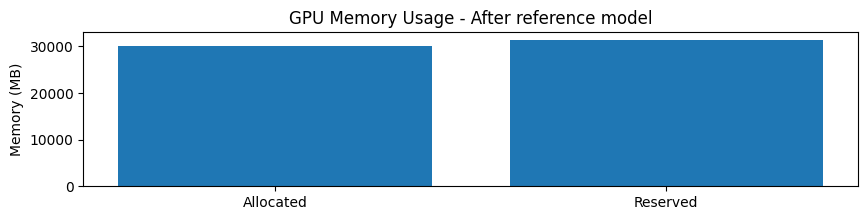

Epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/800 [00:00<?, ?it/s]

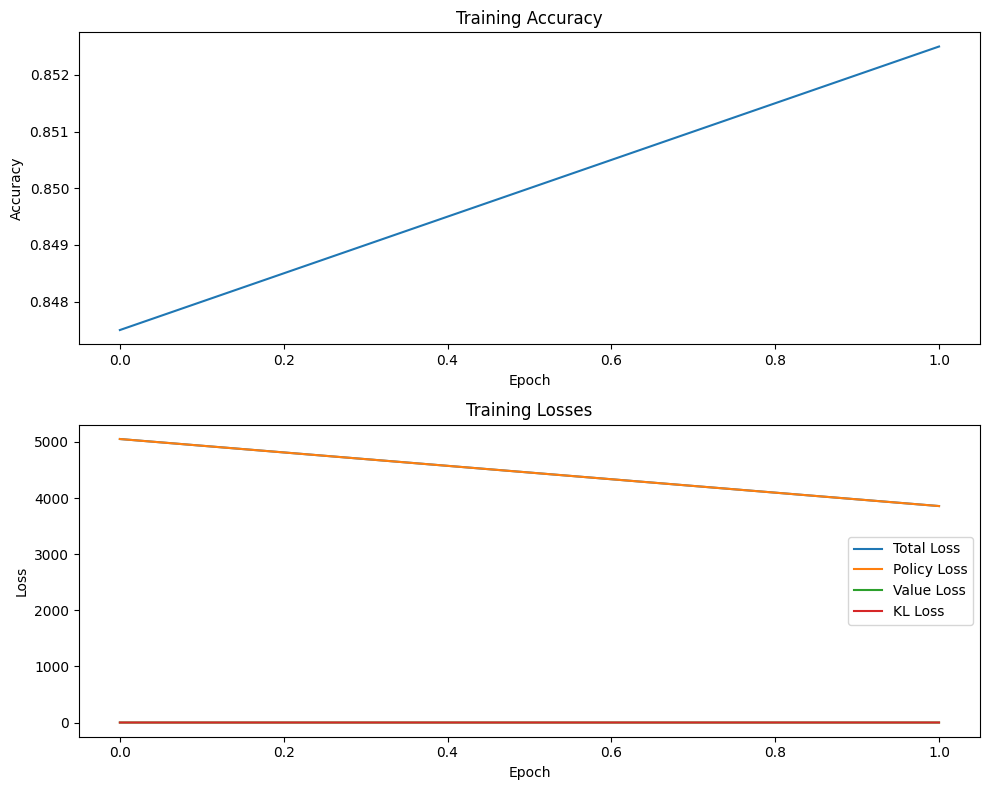

In [25]:
if __name__ == "__main__":
    metrics = run_rlvr_pipeline()

# Section 10: Example Usage After Training


In [26]:
def example_inference():
    """Show an example of using the trained model for inference."""
    # Load the trained model
    trained_model_path = f"{ADAPTER_PATH}/checkpoint-epoch-{NUM_EPOCHS}"

    # Load base model with adapter
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        token=AUTH_TOKEN,
        torch_dtype=torch.float16
    )
    trained_model = PeftModel.from_pretrained(base_model, trained_model_path)

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, token=AUTH_TOKEN)

    # Example question
    question = "John has 5 apples. He buys 3 more apples and then gives 2 apples to his friend. How many apples does John have now?"

    # Format the prompt
    prompt = format_math_prompt(question)
    inputs = tokenizer(prompt, return_tensors="pt").to(trained_model.device)

    # Generate response
    generation_config = {
        "do_sample": True,
        "temperature": 0.7,
        "max_new_tokens": 1000,
        "pad_token_id": tokenizer.pad_token_id,
    }

    with torch.no_grad():
        outputs = trained_model.generate(**inputs, **generation_config)

    # Decode the response
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    print("Question:", question)
    print("\nResponse:")
    print(response)

    # Extract the final answer
    final_answer = extract_answer(response)
    print("\nExtracted Answer:", final_answer)

In [27]:

# Ensure necessary global variables are defined from previous cells:
# BASE_MODEL_NAME, AUTH_TOKEN, ADAPTER_PATH, NUM_EPOCHS, OFFLOAD_FOLDER

# Construct the path to your trained adapter
adapter_path = f"{ADAPTER_PATH}/checkpoint-epoch-{NUM_EPOCHS}"
repo_id = "golyuval/SciGuru-RLVR" # Define your target repo ID

# 1. Load the base model
# Use similar quantization and device mapping as in your training setup for memory efficiency
print(f"Loading base model: {BASE_MODEL_NAME} for pushing adapter...")

if torch.cuda.is_available():
    bnb_config_push = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        llm_int8_enable_fp32_cpu_offload=True
    )
    # Define device_map similar to fix_load_model
    num_layers_base = 32  # Llama-3.1-8B has 32 layers
    device_map_push = {
        "model.embed_tokens": 0,
        "model.norm": 0,
        "lm_head": 0
    }
    gpu_layers_push = 16  # Adjust based on your GPU memory, e.g., half on GPU
    for i in range(num_layers_base):
        if i < gpu_layers_push:
            device_map_push[f"model.layers.{i}"] = 0  # GPU
        else:
            device_map_push[f"model.layers.{i}"] = "cpu"  # CPU

    base_model_for_push = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config_push,
        device_map=device_map_push,
        token=AUTH_TOKEN, # AUTH_TOKEN should be your HF write token
        torch_dtype=torch.float16,
        offload_folder=OFFLOAD_FOLDER, # Ensure OFFLOAD_FOLDER is created
        offload_state_dict=True,
        max_memory={0: "15GiB", "cpu": "30GiB"}, # Adjust if necessary
        low_cpu_mem_usage=True,
    )
else:
    # Load on CPU if no GPU, no quantization
    print("CUDA not available. Loading base model on CPU without quantization for push.")
    base_model_for_push = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        token=AUTH_TOKEN,
        torch_dtype=torch.float16, # Using float16 can still save memory on CPU
        low_cpu_mem_usage=True,
    )


# 2. Load the PeftModel (adapter onto the base model)
print(f"Loading adapter from: {adapter_path}")
model_to_push = PeftModel.from_pretrained(base_model_for_push, adapter_path)

# 3. Push the adapter to Hugging Face Hub
print(f"Pushing adapter to Hugging Face Hub: {repo_id}")
# Ensure AUTH_TOKEN is your HF Write Token
model_to_push.push_to_hub(repo_id, token=AUTH_TOKEN)
print(f"Adapter pushed successfully to https://huggingface.co/{repo_id}")

# 4. Push the tokenizer
print(f"Pushing tokenizer to Hugging Face Hub: {repo_id}")
tokenizer_for_push = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, token=AUTH_TOKEN)
tokenizer_for_push.push_to_hub(repo_id, token=AUTH_TOKEN)
print(f"Tokenizer pushed successfully to https://huggingface.co/{repo_id}")

Loading base model: meta-llama/Llama-3.1-8B-Instruct for pushing adapter...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading adapter from: rlvr_adapter/checkpoint-epoch-2
Pushing adapter to Hugging Face Hub: golyuval/SciGuru-RLVR


adapter_model.safetensors:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Adapter pushed successfully to https://huggingface.co/golyuval/SciGuru-RLVR
Pushing tokenizer to Hugging Face Hub: golyuval/SciGuru-RLVR


No files have been modified since last commit. Skipping to prevent empty commit.


Tokenizer pushed successfully to https://huggingface.co/golyuval/SciGuru-RLVR


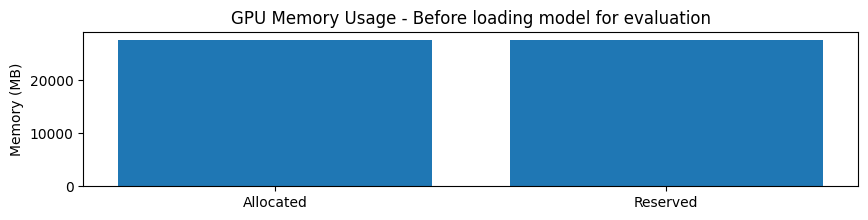

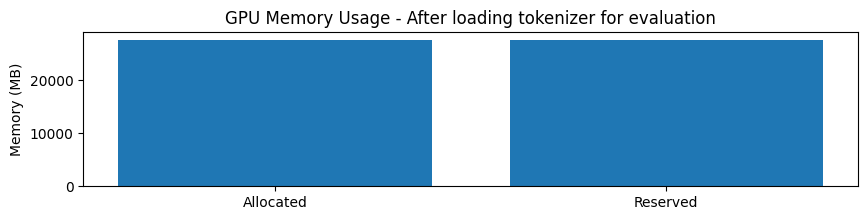

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

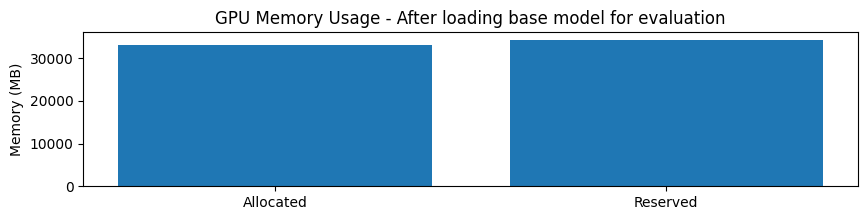

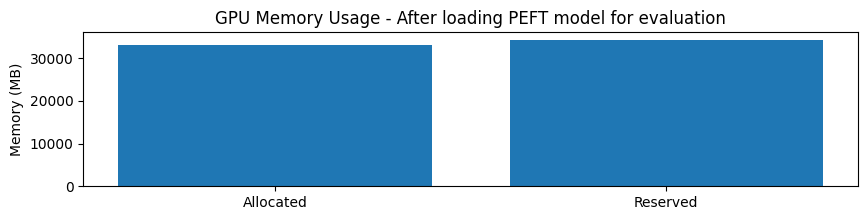

Evaluating on Test Set:   0%|          | 0/50 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

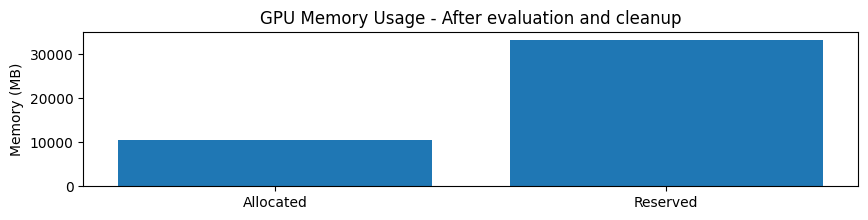

Detailed test results saved to detailed_test_results.json


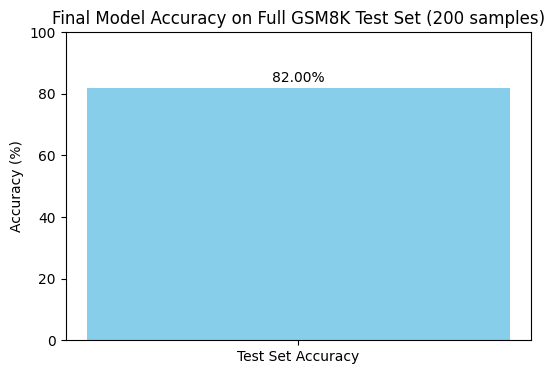


--- Example Correct Answers ---
Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Generated: 18.0
Reference: 18.0

Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
Generated: 3.0
Reference: 3.0

Q: James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  How many total meters does he run a week?
Generated: 540.0
Reference: 540.0


--- Example Incorrect Answers ---
Q: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
Full Generated: Let's break down the problem step by step:

Facts:
- Josh buys a house for $80,000
- He puts in $50,000 in repairs

In [30]:
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# from peft import PeftModel
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt
# import json
# import gc

# Ensure these are defined from your configuration cell:
# BASE_MODEL_NAME, AUTH_TOKEN, ADAPTER_PATH, NUM_EPOCHS, OFFLOAD_FOLDER
# MAX_SEQ_LENGTH (used in prepare_model_inputs)
# BATCH_SIZE (can be adjusted for evaluation)

# Reuse helper functions from your notebook:
# load_gsm8k_dataset, format_math_prompt, prepare_model_inputs,
# generate_responses, extract_answer, verify_answer, log_memory_usage

def evaluate_on_test_set(adapter_checkpoint_path, full_test_ds, batch_size=4):
    """Evaluates a trained PEFT adapter on the full test dataset."""
    logger.info(f"Starting evaluation on the full test set using adapter: {adapter_checkpoint_path}")
    log_memory_usage("Before loading model for evaluation")

    # 1. Load Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, token=AUTH_TOKEN)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    log_memory_usage("After loading tokenizer for evaluation")

    # 2. Load Base Model (with quantization for memory efficiency)
    # Use similar quantization and device mapping as in your training setup
    if torch.cuda.is_available():
        bnb_config_eval = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_enable_fp32_cpu_offload=True
        )
        num_layers_base = 32  # Llama-3.1-8B
        device_map_eval = {"": 0} # Load all on GPU 0 if possible, or adjust like in fix_load_model
                                # For large models, you might need more sophisticated device_map
                                # or load on CPU if GPU memory is insufficient for the base model

        base_model_eval = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            quantization_config=bnb_config_eval,
            device_map=device_map_eval, # or your more complex device_map
            token=AUTH_TOKEN,
            torch_dtype=torch.float16,
            offload_folder=OFFLOAD_FOLDER,
            offload_state_dict=True,
            max_memory={0: "20GiB", "cpu": "30GiB"}, # Adjust based on your GPU
            low_cpu_mem_usage=True,
        )
    else:
        logger.warning("CUDA not available. Loading base model on CPU for evaluation.")
        base_model_eval = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL_NAME,
            token=AUTH_TOKEN,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
        )
    log_memory_usage("After loading base model for evaluation")

    # 3. Load PEFT Model (Adapter)
    eval_model = PeftModel.from_pretrained(base_model_eval, adapter_checkpoint_path)
    eval_model.eval()  # Set to evaluation mode

    if torch.cuda.is_available() and not hasattr(eval_model, 'hf_device_map'): # if not already device_mapped by PeftModel
         eval_model = eval_model.to(base_model_eval.device if hasattr(base_model_eval, 'device') else "cuda")


    log_memory_usage("After loading PEFT model for evaluation")

    # 4. Evaluation Loop
    all_results = []
    correct_answers = 0
    total_questions = 0

    progress_bar_eval = tqdm(range(0, len(full_test_ds), batch_size), desc="Evaluating on Test Set")

    with torch.no_grad():
        for i in progress_bar_eval:
            batch_end = min(i + batch_size, len(full_test_ds))
            batch_questions = [full_test_ds[j]["question"] for j in range(i, batch_end)]
            batch_references = [full_test_ds[j]["answer"] for j in range(i, batch_end)]

            inputs = prepare_model_inputs(tokenizer, batch_questions, eval_model.device, max_length=MAX_SEQ_LENGTH)
            generated_responses = generate_responses(eval_model, tokenizer, inputs, max_new_tokens=1000) # Adjust max_new_tokens if needed

            for idx, (question, generated, reference) in enumerate(zip(batch_questions, generated_responses, batch_references)):
                generated_answer_val = extract_answer(generated)
                is_correct = verify_answer(generated_answer_val, reference)

                all_results.append({
                    "question": question,
                    "generated_full_response": generated,
                    "extracted_generated_answer": generated_answer_val,
                    "reference_answer_full": reference,
                    "reference_answer_extracted": extract_answer(reference), # Extract for comparison
                    "is_correct": is_correct
                })
                if is_correct:
                    correct_answers += 1
                total_questions += 1

            current_accuracy = (correct_answers / total_questions) * 100 if total_questions > 0 else 0
            progress_bar_eval.set_postfix({"Accuracy": f"{current_accuracy:.2f}%"})

    # 5. Calculate Final Accuracy
    final_accuracy = (correct_answers / total_questions) * 100 if total_questions > 0 else 0.0
    logger.info(f"Full Test Set Evaluation Complete.")
    logger.info(f"Total Questions: {total_questions}")
    logger.info(f"Correct Answers: {correct_answers}")
    logger.info(f"Accuracy: {final_accuracy:.2f}%")

    # Clean up to free memory
    del base_model_eval, eval_model, tokenizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    log_memory_usage("After evaluation and cleanup")

    return final_accuracy, all_results

# --- How to use it ---
# 1. Load the full test dataset
_, full_test_dataset = load_gsm8k_dataset() # Assuming load_gsm8k_dataset returns train, test

# 2. Specify the path to your trained adapter checkpoint
# This would typically be the last checkpoint saved by your training script
final_adapter_path = f"{ADAPTER_PATH}/checkpoint-epoch-{NUM_EPOCHS}"

#3. Run the evaluation
test_accuracy, detailed_test_results = evaluate_on_test_set(final_adapter_path, full_test_dataset, batch_size=4)

#4. Save detailed results (optional)
with open("detailed_test_results.json", "w") as f:
    json.dump(detailed_test_results, f, indent=2)
print("Detailed test results saved to detailed_test_results.json")

#5. Plotting the results
plt.figure(figsize=(6, 4))
plt.bar(["Test Set Accuracy"], [test_accuracy], color='skyblue')
plt.ylabel("Accuracy (%)")
plt.title(f"Final Model Accuracy on Full GSM8K Test Set ({len(full_test_dataset)} samples)")
plt.ylim(0, 100)
for i, v in enumerate([test_accuracy]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')
plt.show()

#6. Display some examples of correct and incorrect answers
print("\n--- Example Correct Answers ---")
correct_examples = [res for res in detailed_test_results if res["is_correct"]][:3]
for ex in correct_examples:
    print(f"Q: {ex['question']}")
    print(f"Generated: {ex['extracted_generated_answer']}")
    print(f"Reference: {ex['reference_answer_extracted']}\n")

print("\n--- Example Incorrect Answers ---")
incorrect_examples = [res for res in detailed_test_results if not res["is_correct"]][:3]
for ex in incorrect_examples:
    print(f"Q: {ex['question']}")
    print(f"Full Generated: {ex['generated_full_response']}")
    print(f"Extracted Generated: {ex['extracted_generated_answer']}")
    print(f"Reference: {ex['reference_answer_extracted']}\n")